<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/MachineLeaning/blob/main/%EC%A0%9C%ED%95%9C%EB%90%9C_%EB%B3%BC%EC%B8%A0%EB%A7%8C_%EB%A8%B8%EC%8B%A0(RBM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and preprocessing data...
Initializing RBM...
Training RBM...
Epoch 1/20, Reconstruction Error: 0.0792
Epoch 2/20, Reconstruction Error: 0.0510
Epoch 3/20, Reconstruction Error: 0.0432
Epoch 4/20, Reconstruction Error: 0.0390
Epoch 5/20, Reconstruction Error: 0.0362
Epoch 6/20, Reconstruction Error: 0.0341
Epoch 7/20, Reconstruction Error: 0.0324
Epoch 8/20, Reconstruction Error: 0.0311
Epoch 9/20, Reconstruction Error: 0.0300
Epoch 10/20, Reconstruction Error: 0.0290
Epoch 11/20, Reconstruction Error: 0.0282
Epoch 12/20, Reconstruction Error: 0.0274
Epoch 13/20, Reconstruction Error: 0.0268
Epoch 14/20, Reconstruction Error: 0.0262
Epoch 15/20, Reconstruction Error: 0.0256
Epoch 16/20, Reconstruction Error: 0.0251
Epoch 17/20, Reconstruction Error: 0.0247
Epoch 18/20, Reconstruction Error: 0.0242
Epoch 19/20, Reconstruction Error: 0.0239
Epoch 20/20, Reconstruction Error: 0.0235
Plotting learning curve...


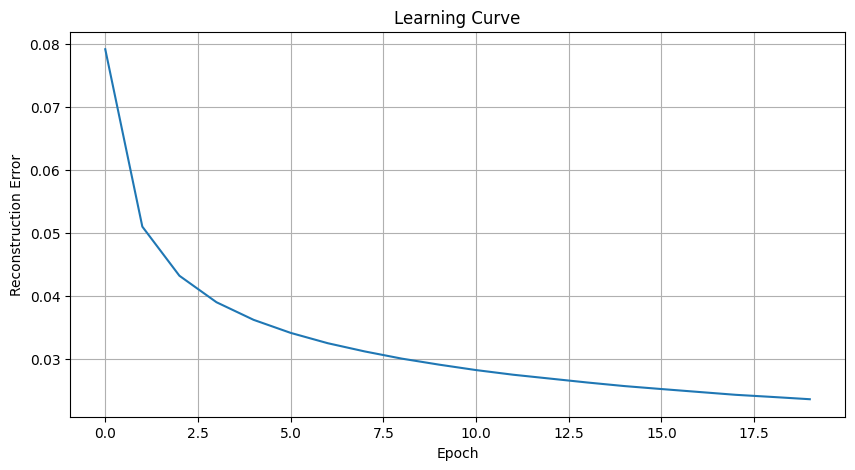

Reconstructing test samples...
Visualizing results...


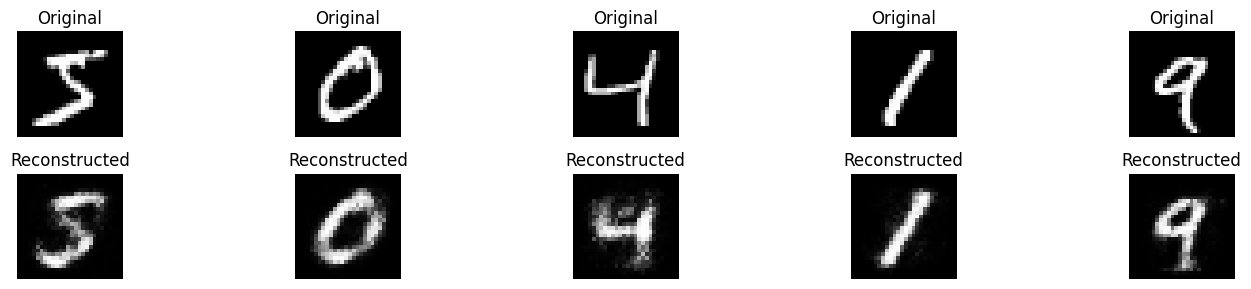

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler

class RestrictedBoltzmannMachine:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        """
        제한된 볼츠만 머신 초기화

        Parameters:
        n_visible (int): 가시층의 뉴런 수
        n_hidden (int): 은닉층의 뉴런 수
        learning_rate (float): 학습률
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate

        # 가중치와 바이어스 초기화
        self.weights = np.random.randn(n_visible, n_hidden) * 0.1
        self.hidden_bias = np.zeros(n_hidden)
        self.visible_bias = np.zeros(n_visible)

    def sigmoid(self, x):
        """시그모이드 활성화 함수"""
        return 1 / (1 + np.exp(-x))

    def compute_hidden_probabilities(self, visible_states):
        """은닉층의 활성화 확률 계산"""
        hidden_activations = np.dot(visible_states, self.weights) + self.hidden_bias
        hidden_probabilities = self.sigmoid(hidden_activations)
        return hidden_probabilities

    def compute_visible_probabilities(self, hidden_states):
        """가시층의 활성화 확률 계산"""
        visible_activations = np.dot(hidden_states, self.weights.T) + self.visible_bias
        visible_probabilities = self.sigmoid(visible_activations)
        return visible_probabilities

    def sample_states(self, probabilities):
        """확률에 따른 상태 샘플링"""
        return (probabilities > np.random.random(probabilities.shape)).astype(np.float32)

    def train(self, data, n_epochs=10, batch_size=100):
        """
        RBM 학습

        Parameters:
        data: 학습 데이터
        n_epochs: 학습 반복 횟수
        batch_size: 미니배치 크기
        """
        n_samples = len(data)
        n_batches = n_samples // batch_size

        reconstruction_errors = []

        for epoch in range(n_epochs):
            epoch_error = 0

            # 미니배치 학습
            for batch_idx in range(n_batches):
                start = batch_idx * batch_size
                end = start + batch_size
                batch = data[start:end]

                # Positive phase
                pos_hidden_probs = self.compute_hidden_probabilities(batch)
                pos_hidden_states = self.sample_states(pos_hidden_probs)
                pos_associations = np.dot(batch.T, pos_hidden_probs)

                # Negative phase
                neg_visible_probs = self.compute_visible_probabilities(pos_hidden_states)
                neg_hidden_probs = self.compute_hidden_probabilities(neg_visible_probs)
                neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

                # 가중치와 바이어스 업데이트
                self.weights += self.learning_rate * (pos_associations - neg_associations) / batch_size
                self.visible_bias += self.learning_rate * np.mean(batch - neg_visible_probs, axis=0)
                self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

                # 재구성 에러 계산
                batch_error = np.mean((batch - neg_visible_probs) ** 2)
                epoch_error += batch_error

            epoch_error /= n_batches
            reconstruction_errors.append(epoch_error)

            if (epoch + 1) % 1 == 0:
                print(f'Epoch {epoch + 1}/{n_epochs}, Reconstruction Error: {epoch_error:.4f}')

        return reconstruction_errors

    def reconstruct(self, data):
        """입력 데이터 재구성"""
        hidden_probs = self.compute_hidden_probabilities(data)
        hidden_states = self.sample_states(hidden_probs)
        visible_probs = self.compute_visible_probabilities(hidden_states)
        return visible_probs

# 데이터 로드 및 전처리
def load_and_preprocess_data():
    # MNIST 데이터셋 로드
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    X = mnist.data[:10000]  # 처음 10000개 샘플만 사용

    # 데이터 정규화
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    return X

# 결과 시각화 함수
def visualize_results(original_data, reconstructed_data, n_samples=5):
    plt.figure(figsize=(15, 3))

    for i in range(n_samples):
        # 원본 이미지
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(original_data[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title('Original')

        # 재구성된 이미지
        plt.subplot(2, n_samples, n_samples + i + 1)
        plt.imshow(reconstructed_data[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')

    plt.tight_layout()
    plt.show()

def plot_learning_curve(errors):
    plt.figure(figsize=(10, 5))
    plt.plot(errors)
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Error')
    plt.grid(True)
    plt.show()

# 메인 실행 코드
def main():
    # 데이터 로드 및 전처리
    print("Loading and preprocessing data...")
    X = load_and_preprocess_data()

    # RBM 모델 초기화
    print("Initializing RBM...")
    rbm = RestrictedBoltzmannMachine(n_visible=784, n_hidden=256, learning_rate=0.01)

    # 모델 학습
    print("Training RBM...")
    reconstruction_errors = rbm.train(X, n_epochs=20, batch_size=100)

    # 학습 곡선 시각화
    print("Plotting learning curve...")
    plot_learning_curve(reconstruction_errors)

    # 테스트 데이터 재구성
    print("Reconstructing test samples...")
    test_samples = X[:5]  # 처음 5개 샘플 사용
    reconstructed_samples = rbm.reconstruct(test_samples)

    # 결과 시각화
    print("Visualizing results...")
    visualize_results(test_samples, reconstructed_samples)

if __name__ == "__main__":
    main()